### PyTorch Datasets ###

In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import logging
import albumentations as alb
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# From the HuggingFace library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor
from transformers import TrainingArguments, Trainer

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData, is_image, yolo2xywh, xywh2yolo
from computervision.transformations import DETRansform

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

xrays_dir = os.path.join(data_dir, 'dentex', 'cropped')

# Load the annotations with data splits
parquet_file_name = 'train_quadrant_enumeration_dset.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')

data_dir: /app/data


In [3]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

In [4]:
# Let's validate the image data before we do anything else
for file_name in df['file_name'].unique():
    bad_files = []
    if not is_image(os.path.join(xrays_dir, file_name)):
        bad_files.append(file_name)
if len(bad_files) == 0:
    print('All files are good!')
else:
    print(f'Could not open these files: \n {bad_files}')

All files are good!


In [36]:
display(df.head())

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4,train


Found 4 images for base image train_109


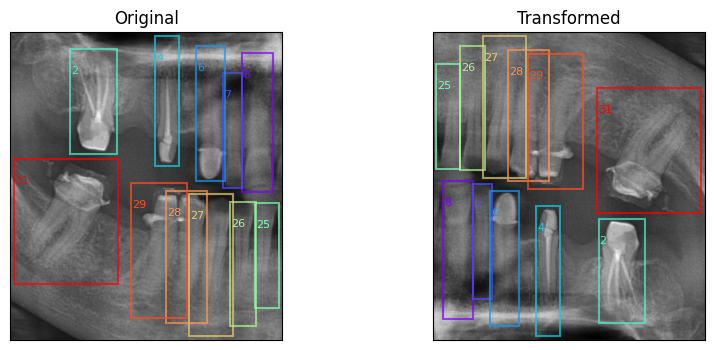

In [49]:
# Check the data
px_idx = 12
file_base_name = df['file_base_name'].unique()[px_idx]

# Get the cropped images and pick one
file_name_list = df.loc[df['file_base_name'] == file_base_name, 'file_name'].unique()
print(f'Found {len(file_name_list)} images for base image {file_base_name}')
crop_idx = 2
file_name = file_name_list[crop_idx]

# Load the image and bounding boxes for this file
df_file = df.loc[df['file_name'] == file_name]
file = os.path.join(xrays_dir, file_name)

# Load the image
im = ImageData().load_image(file)

# Convert to RGB
im = ImageData().np2color(im)

# Bounding boxes and labels
bboxes = df_file['bbox'].tolist()
labels = df_file['ada'].tolist()

# Image transformation
bbox_format = {'format': 'coco',
               'label_fields': ['tooth_position'],
               'clip': True}
transformations = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]
detr = DETRansform(bbox_format=bbox_format, transformations=transformations)
transformed_im, transformed_annotations = detr.\
    format_transform(image=im, image_id=crop_idx, bboxes=bboxes, labels=labels)

# Annotations after the transform
transformed_bboxes = [annotation['bbox'] for annotation in transformed_annotations['annotations']]
transformed_labels = [annotation['category_id'] for annotation in transformed_annotations['annotations']]

# Show the image with the bounding boxes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0] = plot_boxes(image=im, box_list=bboxes, ax=ax[0], label_list=labels)
ax[0].set(title='Original')
ax[1] = plot_boxes(image=transformed_im, box_list=transformed_bboxes, label_list=transformed_labels, ax=ax[1])
ax[1].set(title='Transformed')
plt.show()

In [54]:
# Image processing for the model input
model_checkpoint = 'PekingU/rtdetr_v2_r101vd'
image_processor_params = {'format': 'coco_detection'}
image_processor = RTDetrImageProcessor(image_processor_params)

# Process the image and annotations
proc = image_processor.from_pretrained(model_checkpoint)
output = proc(images=transformed_im, annotations=transformed_annotations, return_tensors='pt')

# The output is a list of images and annotations
print(len(output))

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

2


2

In [28]:
transformed_annotations['annotations']

[{'image_id': 2,
  'category_id': 8,
  'bbox': [608, 54, 79, 364],
  'iscrowd': 0,
  'area': 28756},
 {'image_id': 2,
  'category_id': 7,
  'bbox': [559, 108, 50, 301],
  'iscrowd': 0,
  'area': 15050},
 {'image_id': 2,
  'category_id': 6,
  'bbox': [487, 36, 76, 353],
  'iscrowd': 0,
  'area': 26828},
 {'image_id': 2,
  'category_id': 4,
  'bbox': [379, 10, 63, 341],
  'iscrowd': 0,
  'area': 21483},
 {'image_id': 2,
  'category_id': 2,
  'bbox': [156, 43, 123, 274],
  'iscrowd': 0,
  'area': 33702},
 {'image_id': 2,
  'category_id': 25,
  'bbox': [641, 447, 63, 276],
  'iscrowd': 0,
  'area': 17388},
 {'image_id': 2,
  'category_id': 26,
  'bbox': [577, 445, 67, 326],
  'iscrowd': 0,
  'area': 21842},
 {'image_id': 2,
  'category_id': 27,
  'bbox': [470, 423, 113, 375],
  'iscrowd': 0,
  'area': 42375},
 {'image_id': 2,
  'category_id': 28,
  'bbox': [409, 417, 108, 345],
  'iscrowd': 0,
  'area': 37260},
 {'image_id': 2,
  'category_id': 29,
  'bbox': [318, 395, 145, 356],
  'iscrow